In [2]:
%pylab inline
import gc
import numpy as np
import astropy.io.fits as pyfits

import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


In [24]:
def estimate(Clist=np.array([0.2,0.3,0.4,0.5]),noiRev=True):
    C=500.
    nsim=800
    vdir='outcome-var7em3'
    nic=len(Clist)
    gest=np.zeros((nsim,nic))
    slow=0.0
    dss=0.01
    for ifield in range(nsim):
        igroup=ifield//250
        fname1=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
        moments1=pyfits.getdata(fname1)
        fname2=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
        moments2=pyfits.getdata(fname2)

        for ic in range(nic):
            slow=Clist[ic]
            elli1=fpfsBase.fpfsM2E(moments1,C,rev=noiRev)
            mask=elli1['fpfs_s0']>slow
            elli1=elli1[mask]
            mask2=elli1['fpfs_s0']<slow+dss
            RS=-np.sum(elli1[mask2]['fpfs_RS'])/dss
            g1p=np.sum(elli1['fpfs_e1'])/(np.sum(elli1['fpfs_RE'])+RS)

            elli2=fpfsBase.fpfsM2E(moments2,C,rev=noiRev)
            mask=elli2['fpfs_s0']>slow
            elli2=elli2[mask]
            mask2=elli2['fpfs_s0']<slow+dss
            RS=-np.sum(elli2[mask2]['fpfs_RS'])/dss
            g1m=np.sum(elli2['fpfs_e1'])/(np.sum(elli2['fpfs_RE'])+RS)

            gest[ifield,ic]=g1m-g1p
            del elli1,elli2,mask,mask2
            gc.collect
        del moments1,moments2
        gc.collect
    return np.average(gest,axis=0)/0.04-1,np.std(gest,axis=0)/0.04/np.sqrt(nsim)

In [25]:
Clist=np.array([0.2,0.3,0.4,0.5,0.6])
mT,merrT=estimate(Clist,True)
mF,merrF=estimate(Clist,False)

Text(0, 0.5, 'Multiplicative bias')

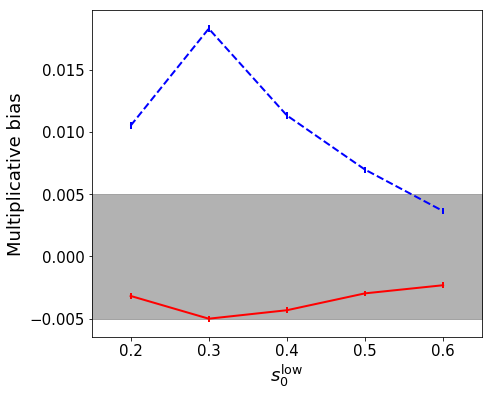

In [30]:
pltDir='plot/selBias/'
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.errorbar(Clist,mT,merrT,fmt='-',c='red')
ax.errorbar(Clist,mF,merrF,fmt='--',c='blue')
ax.fill_between(np.linspace(0.15,0.65,100),-5e-3*np.ones(100),5e-3*np.ones(100),color='gray',alpha=0.6)
ax.set_xlim(0.15,0.65)
ax.set_xlabel(r'$s_0^{\rm low}$')
ax.set_ylabel(r'Multiplicative bias')

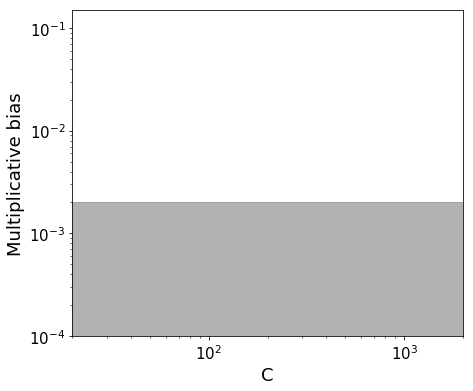

In [6]:
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-4,1.5e-1)